Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from numpy import log
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import pacf
from keras.models import Sequential
from keras.layers.core import Dense, Activation
import keras
import math
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM, SimpleRNN
from keras.layers import Dense
from statsmodels.tsa.stattools import pacf
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense



import warnings
warnings.filterwarnings('ignore')

# 📒  1. Load Nvidia Stock Price data

In [2]:
dataset = pd.read_csv('/kaggle/input/nvidia-amd-intel-asus-msi-share-prices/NVIDIA (1999-2023).csv')
dataset.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1999-01-25,0.442708,0.458333,0.410156,0.453125,0.415786,51048000
1,1999-01-26,0.458333,0.467448,0.411458,0.417969,0.383527,34320000
2,1999-01-27,0.419271,0.429688,0.395833,0.416667,0.382332,24436800
3,1999-01-28,0.416667,0.419271,0.412760,0.415365,0.381137,22752000
4,1999-01-29,0.415365,0.416667,0.395833,0.395833,0.363215,24403200


In [3]:
dataset.describe()

,Open,High,Low,Close,Adj Close,Volume
count,6094.000000,6094.000000,6094.000000,6094.000000,6094.000000,6.094000e+03
mean,30.987375,31.585369,30.369141,31.003835,30.743154,6.134634e+07
std,59.862014,61.089822,58.564768,59.881405,59.882440,4.399760e+07
min,0.348958,0.355469,0.333333,0.341146,0.313034,1.968000e+06
25%,2.671094,2.750000,2.598027,2.670208,2.450174,3.440110e+07
50%,4.285000,4.377500,4.210000,4.290000,3.946429,5.151250e+07
75%,26.690000,27.198125,26.404999,26.818125,26.440031,7.462690e+07
max,335.170013,346.470001,320.359985,333.760010,333.350800,9.230856e+08


# 📊 2. EDA on Nvidia Stock Data

## Checking for any null values present in the dataset

In [4]:
dataset.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

## Plotting Few price data

In [5]:
start_date = pd.to_datetime(dataset.Date[0])
end_date = pd.to_datetime(dataset.Date.values[-1])
dataset['Date'] = pd.to_datetime(dataset['Date'])

In [6]:
dataset.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
6089,2023-04-05,268.290009,269.980011,263.950012,268.809998,268.809998,51501500
6090,2023-04-06,265.839996,270.799988,264.269989,270.369995,270.369995,39765400
6091,2023-04-10,268.230011,276.209991,266.690002,275.790009,275.790009,39527900
6092,2023-04-11,277.239990,277.899994,271.260010,271.690002,271.690002,31437800
6093,2023-04-12,273.700012,274.679993,264.480011,264.950012,264.950012,44529900


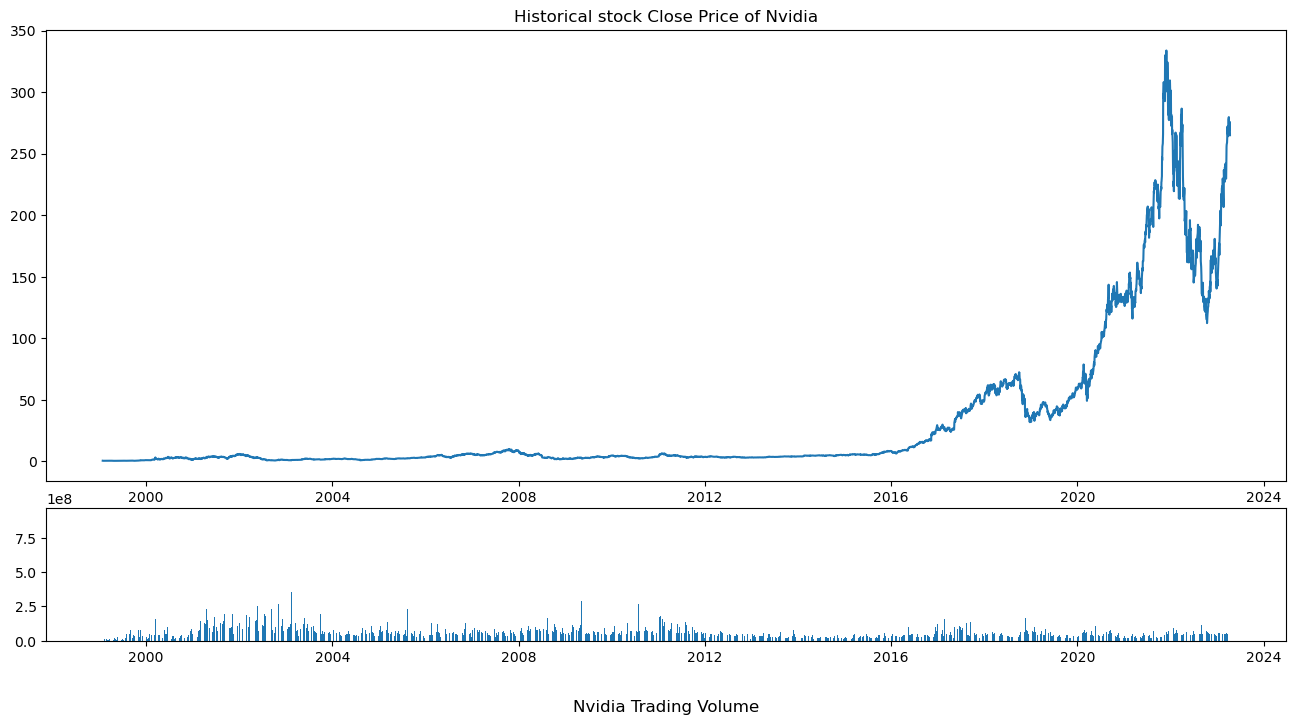

In [7]:
top_plt = plt.subplot2grid((5,4), (0, 0), rowspan = 3, colspan = 4)
top_plt.plot(dataset.Date, dataset["Close"])
plt.title('Historical stock Close Price of Nvidia')
bottom_plt = plt.subplot2grid((5,4), (3,0), rowspan = 1, colspan = 4)
bottom_plt.bar(dataset.Date, dataset['Volume'])
plt.title('\nNvidia Trading Volume', y = -0.60)
plt.gcf().set_size_inches(16,10)

In [8]:
dataset.describe()

,Open,High,Low,Close,Adj Close,Volume
count,6094.000000,6094.000000,6094.000000,6094.000000,6094.000000,6.094000e+03
mean,30.987375,31.585369,30.369141,31.003835,30.743154,6.134634e+07
std,59.862014,61.089822,58.564768,59.881405,59.882440,4.399760e+07
min,0.348958,0.355469,0.333333,0.341146,0.313034,1.968000e+06
25%,2.671094,2.750000,2.598027,2.670208,2.450174,3.440110e+07
50%,4.285000,4.377500,4.210000,4.290000,3.946429,5.151250e+07
75%,26.690000,27.198125,26.404999,26.818125,26.440031,7.462690e+07
max,335.170013,346.470001,320.359985,333.760010,333.350800,9.230856e+08


## Checking for Correlation

<AxesSubplot:>

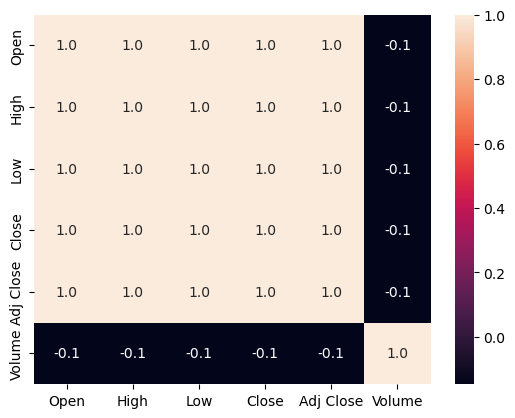

In [9]:
# plotting correlation heatmap
sns.heatmap(dataset.corr(), annot = True, fmt = ".1f")

We go forward with the features : Close and Volume

In [10]:
dataset2 = dataset[['Close', 'Volume']]
dataset2.head()

,Close,Volume
0,0.453125,51048000
1,0.417969,34320000
2,0.416667,24436800
3,0.415365,22752000
4,0.395833,24403200


## Stationarity and detrending (ADF/KPSS)

Stationarity means that the statistical properties of a time series i.e. mean, variance and covariance do not change over time. Many statistical models require the series to be stationary to make effective and precise predictions.

Two statistical tests would be used to check the stationarity of a time series – Augmented Dickey Fuller (“ADF”) test and Kwiatkowski-Phillips-Schmidt-Shin (“KPSS”) test. A method to convert a non-stationary time series into stationary series shall also be used.

## ADF Test

ADF test is used to determine the presence of unit root in the series, and hence helps in understand if the series is stationary or not. The null and alternate hypothesis of this test are:

1. Null Hypothesis: The series has a unit root.
2. Alternate Hypothesis: The series has no unit root.

If the null hypothesis in failed to be rejected, this test may provide evidence that the series is non-stationary.

In [11]:
result = adfuller(dataset2.Close.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: 0.9024032605647256
p-value: 0.993121609513949
Critial Values:
   1%, -3.431429371666765
Critial Values:
   5%, -2.8620169839390432
Critial Values:
   10%, -2.5670238959668166


Conclusion : 

ADF Test Statistic value is smaller than all critical values but p-value is also greater than 0.05.

So we can strongly reject the null hypothesis, and conclude that, Price value is Non-Stationary.


## KPSS test 

KPSS is another test for checking the stationarity of a time series. The null and alternate hypothesis for the KPSS test are opposite that of the ADF test.

1. Null Hypothesis: The process is trend stationary.    
2. Alternate Hypothesis: The series has a unit root (series is not stationary).

In [12]:
result = kpss(dataset2['Close'].values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])

for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}');


KPSS Statistic: 6.540591
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


Conclusion :

Here we find that, KPSS stats value is too high than critical values. 

So, we concluded that this time series is Non-Stationary

# 📙 3. Time Series Prediction

## Models considered : 

  **<span style='color:#2980B9'>ARIMA  </span>**
    
  **<span style='color:#2980B9'>NEURAL NETWORK  </span>**
    
  **<span style='color:#2980B9'>RECURRENT NEURAL NETWORK  </span>**
    
  **<span style='color:#2980B9'>LSTM - LONG SHORT TERM MEMORY  </span>**

## ARIMA - Univariate Price Forecasting

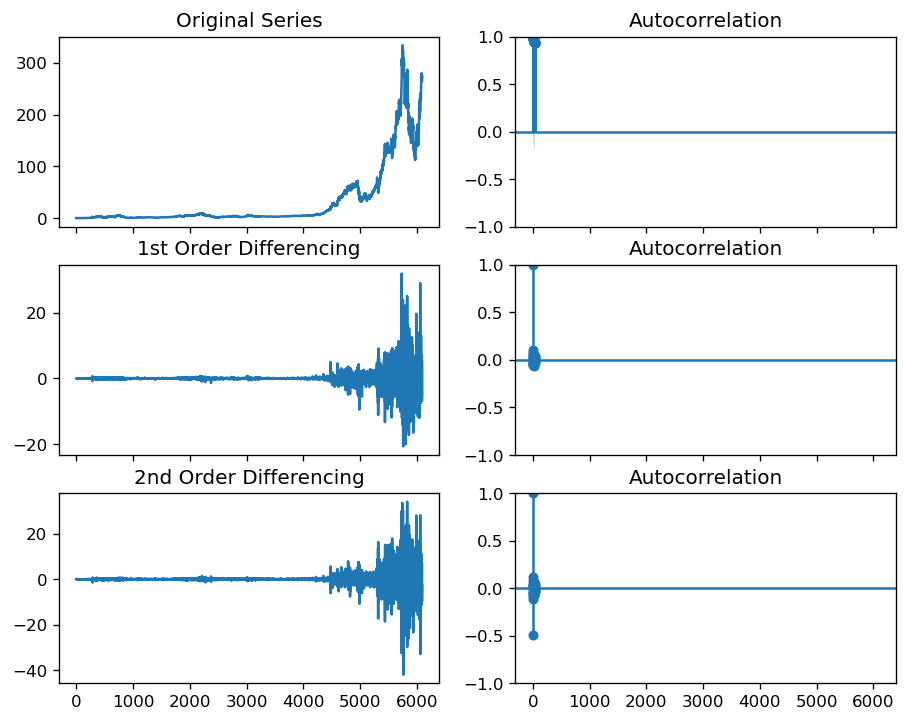

In [13]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex = True)
axes[0, 0].plot(dataset2['Close'].values); axes[0, 0].set_title('Original Series')
plot_acf(dataset2['Close'].values, ax = axes[0, 1])

# 1st Differencing
axes[1, 0].plot(dataset2['Close'].diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(dataset2['Close'].diff().dropna(), ax = axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(dataset2['Close'].diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(dataset2['Close'].diff().diff().dropna(), ax = axes[2, 1])

plt.show()

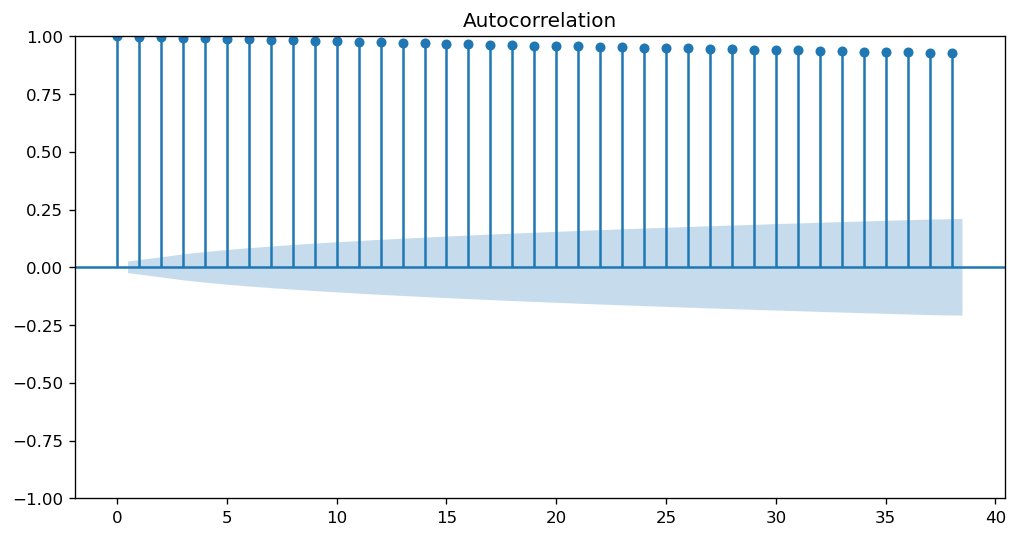

In [14]:
plt.rc("figure", figsize = (10,5))
plot_acf(dataset2['Close'])
print()

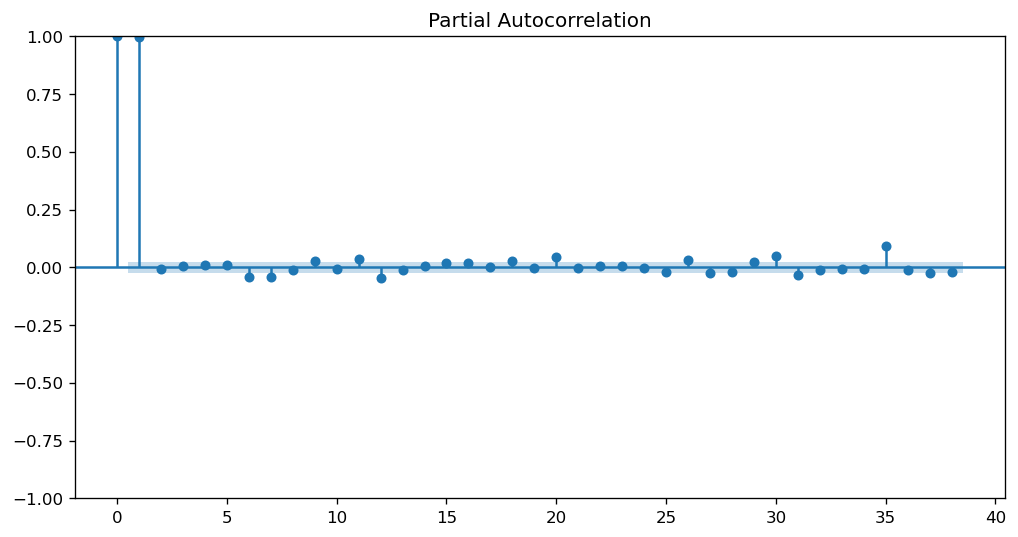

In [15]:
plt.rc("figure", figsize=(10,5))
plot_pacf(dataset2['Close'])
print()

We can observe that the PACF lag 2 is the only one that is quite significant and it is well above the significance line compared to other values. Hence, we can safely set p to 2.

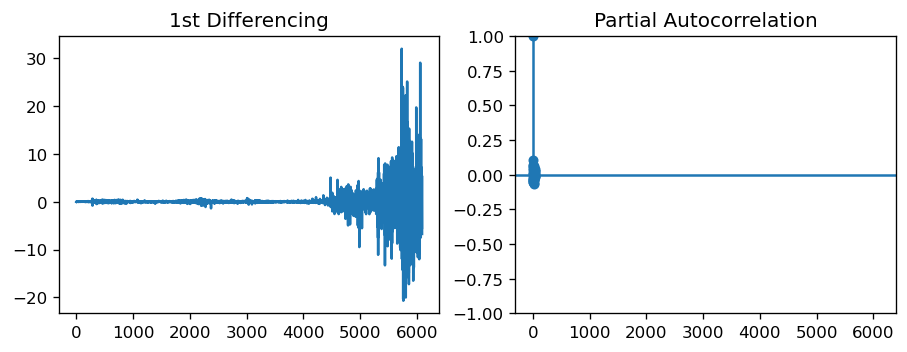

In [16]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex = True)
axes[0].plot(dataset2['Close'].diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim = (0,5))
plot_pacf(dataset2['Close'].diff().dropna(), ax = axes[1])

plt.show()

### Determining the order of the MA term  

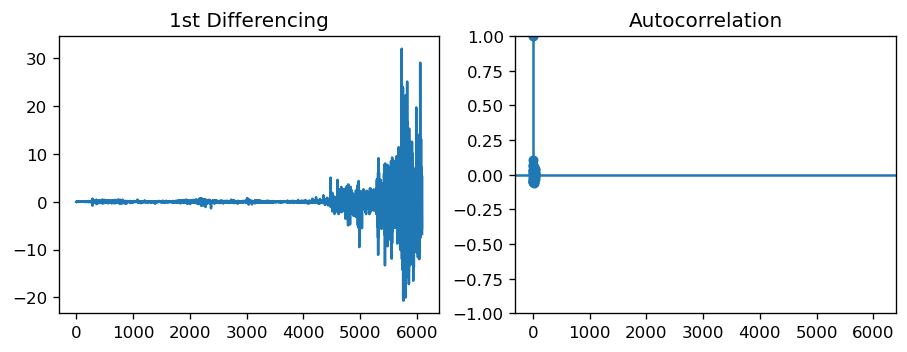

In [17]:
fig, axes = plt.subplots(1, 2, sharex = True)
axes[0].plot(dataset2['Close'].diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim = (0,1.2))
plot_acf(dataset2['Close'].diff().dropna(), ax=axes[1])

plt.show()

In [18]:
data = dataset2['Close'].values
print('Length of Total data: ', len(data))
train_length = int(len(data) * 0.8)
train_data = data[:train_length]
test_data = data[train_length:]
print('Train and Test data length: ', len(train_data), len(test_data))

Length of Total data:  6094
Train and Test data length:  4875 1219


### Building ARIMA Model  

In [19]:
model = ARIMA(train_data, order = (1,0,8))
model_fit = model.fit(low_memory = False)
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4875
Model:                 ARIMA(1, 0, 8)   Log Likelihood               -1615.926
Date:                Tue, 25 Apr 2023   AIC                           3253.851
Time:                        06:54:55   BIC                           3325.262
Sample:                             0   HQIC                          3278.912
                               - 4875                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.2137    220.189      0.033      0.974    -424.349     438.776
ar.L1          1.0000      0.000   9735.979      0.000       1.000       1.000
ma.L1         -0.0915      0.004    -23.955      0.0

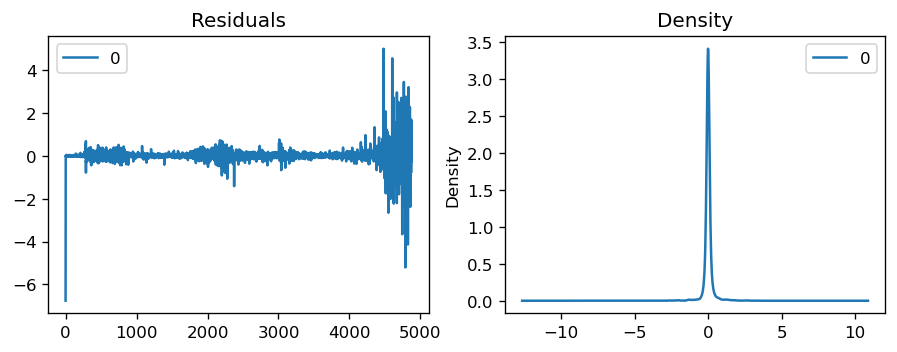

In [20]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title = "Residuals", ax = ax[0])
residuals.plot(kind = 'kde', title = 'Density', ax = ax[1])
plt.show()

In [21]:
# Forecast
forecast_result = model_fit.forecast(150, alpha = 0.05)  # 95% conf
forecast_result[:30]

array([65.78888573, 65.55680053, 65.54796114, 65.48469493, 65.3260891 ,
       65.26561546, 65.2445946 , 65.33117371, 65.32932259, 65.32747153,
       65.32562053, 65.32376959, 65.32191871, 65.32006788, 65.31821712,
       65.31636641, 65.31451576, 65.31266517, 65.31081464, 65.30896417,
       65.30711376, 65.30526341, 65.30341312, 65.30156288, 65.2997127 ,
       65.29786259, 65.29601253, 65.29416253, 65.29231259, 65.29046271])

In [22]:
test_data[:30]

array([65.57    , 65.154999, 65.644997, 65.599998, 66.727501, 66.315002,
       66.272499, 65.042503, 65.577499, 64.277496, 62.737499, 59.779999,
       60.497501, 58.93    , 60.215   , 59.224998, 60.560001, 59.209999,
       60.682499, 61.8325  , 62.3125  , 63.3125  , 61.8825  , 62.807499,
       62.330002, 62.049999, 63.422501, 62.924999, 63.0075  , 62.7225  ])

### Plotting Test and Predicted Results  

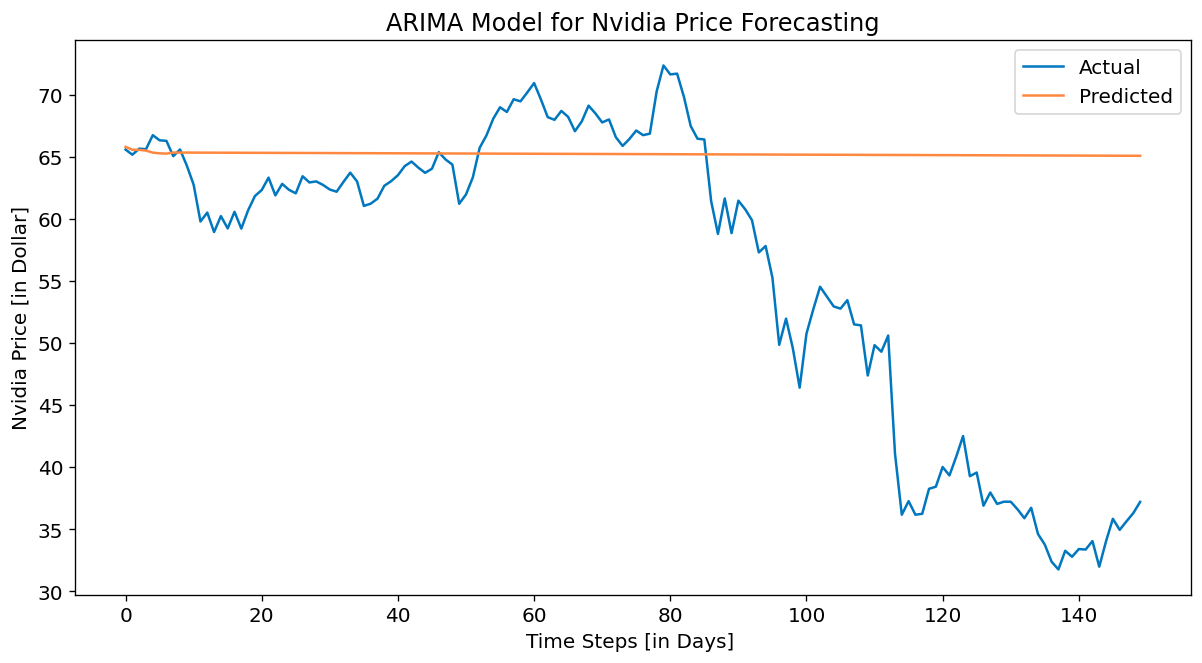

In [23]:
# Here we're plotting Test and Predicted data

plt.figure(figsize = (12, 6))
plt.rcParams.update({'font.size': 12})
plt.plot(test_data[:150], '#0077be',label = 'Actual')
plt.plot(forecast_result[:], '#ff8841',label = 'Predicted')
plt.title('ARIMA Model for Nvidia Price Forecasting')
plt.ylabel('Nvidia Price [in Dollar]')
plt.xlabel('Time Steps [in Days] ')
plt.legend()
plt.show()

## Artificial Neural Network 

In [24]:
data = dataset2['Close'].values
print('Shape of data: ', data.shape)

Shape of data:  (6094,)


In [25]:
# Separating train and test data
train_length = int(len(data) * 0.8)
print('Train length: ', train_length)

train_data, test_data = data[:train_length], data[train_length:]
print('Shape of Train and Test data: ', train_data.shape, test_data.shape)

Train length:  4875
Shape of Train and Test data:  (4875,) (1219,)


Changing dataset shape to 2D

In [26]:
train_data = train_data.reshape(-1, 1)
test_data = test_data.reshape(-1, 1)
print('Shape of Train and Test data: ', train_data.shape, test_data.shape)

Shape of Train and Test data:  (4875, 1) (1219, 1)


In [27]:
def create_dataset(dataset, lookback):
    dataX, dataY = [], []
    for i in range(len(dataset) - lookback -1):
        a = dataset[i: (i+lookback), 0]
        dataX.append(a)
        b = dataset[i+lookback, 0]
        dataY.append(b)
    return np.array(dataX), np.array(dataY)

### Selecting Lag value from PACF graph

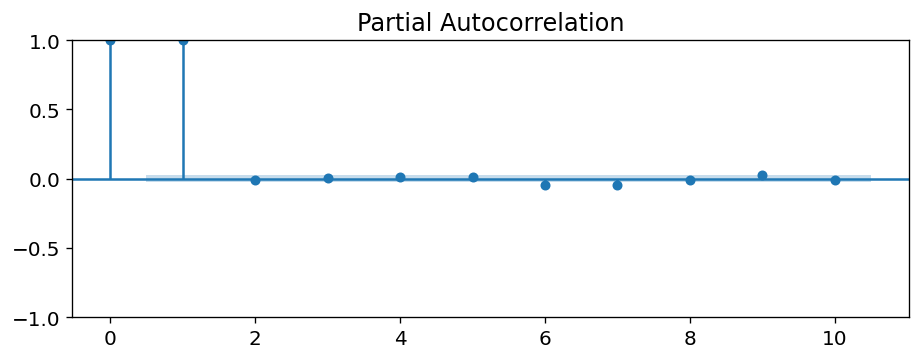

In [28]:
plot_pacf(data, lags = 10)
plt.show()

### Considering only Auto-correlation Lag value Greater than 10%

In [29]:
pacf_value = pacf(data, nlags=20)
lag = 0
# collect lag values greater than 10% correlation 
for x in pacf_value:
    if x > 0.1:
        lag += 1
    else:
        break
print('Selected look_back (or lag = ): ', lag)

Selected look_back (or lag = ):  2


### Separating Input and Output values

In [30]:
train_X, train_y = create_dataset(train_data, lag)
test_X, test_y = create_dataset(test_data, lag)

In [31]:
print('Shape of train_X and train_y: ', train_X.shape, train_y.shape)
print('Shape of test_X and test_y: ', test_X.shape, test_y.shape)

Shape of train_X and train_y:  (4872, 2) (4872,)
Shape of test_X and test_y:  (1216, 2) (1216,)


### Building an MLP model

In [32]:
np.random.seed(7)

In [33]:
model = Sequential()
model.add(Dense(64, input_dim = lag, activation='relu', name= "1st_hidden"))
# model.add(Dense(64, activation='relu', name = '2nd_hidden'))
model.add(Dense(1, name = 'Output_layer', activation = 'linear'))
# model.add(Activation("linear", name = 'Linear_activation'))
model.compile(loss = "mean_squared_error", optimizer = "adam")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 1st_hidden (Dense)          (None, 64)                192       
                                                                 
 Output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 257
Trainable params: 257
Non-trainable params: 0
_________________________________________________________________


### Fitting data to Model

In [34]:
epoch_number = 100
batches = 64

history = model.fit(train_X, train_y, epochs = epoch_number, batch_size = batches, verbose = 1, shuffle = False, 
                    validation_split = 0.1)

Epoch 1/100
69/69 [==============================] - 1s 5ms/step - loss: 2.3838 - val_loss: 19.7821
Epoch 2/100
69/69 [==============================] - 0s 2ms/step - loss: 0.0547 - val_loss: 7.0815
Epoch 3/100
69/69 [==============================] - 0s 2ms/step - loss: 0.0422 - val_loss: 5.2228
Epoch 4/100
69/69 [==============================] - 0s 2ms/step - loss: 0.0379 - val_loss: 4.0413
Epoch 5/100
69/69 [==============================] - 0s 2ms/step - loss: 0.0334 - val_loss: 3.0672
Epoch 6/100
69/69 [==============================] - 0s 2ms/step - loss: 0.0295 - val_loss: 2.3330
Epoch 7/100
69/69 [==============================] - 0s 2ms/step - loss: 0.0263 - val_loss: 1.8247
Epoch 8/100
69/69 [==============================] - 0s 2ms/step - loss: 0.0239 - val_loss: 1.5025
Epoch 9/100
69/69 [==============================] - 0s 2ms/step - loss: 0.0223 - val_loss: 1.3129
Epoch 10/100
69/69 [==============================] - 0s 2ms/step - loss: 0.0212 - val_loss: 1.2094
Epoch 11

### Train and Validation Loss

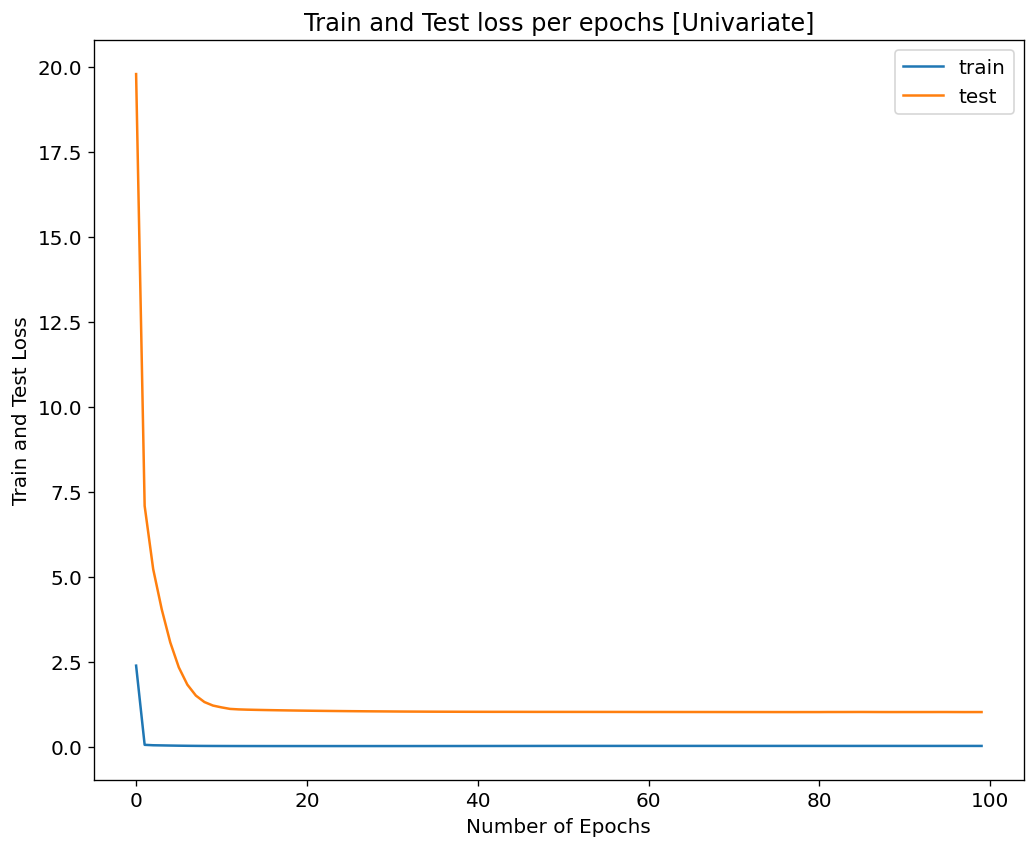

In [35]:
# plot history
plt.clf
plt.figure(figsize = (10,8))
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.xlabel('Number of Epochs')
plt.ylabel('Train and Test Loss')
plt.title('Train and Test loss per epochs [Univariate]')
plt.legend()
plt.show()

### Making Predictions

In [36]:
# Make prediction
testPredict = model.predict(test_X)
predicted_value = testPredict[:, 0]

38/38 [==============================] - 0s 1ms/step


### Evaluation Metrics for measuring performance

* **<span style='color:#0A7681'> R-Squared </span>**

* **<span style='color:#0A7681'> Mean Absolute Error </span>**

* **<span style='color:#0A7681'> Mean Absolute Percentage Error</span>**

* **<span style='color:#0A7681'> Mean Squared Error</span>**

* **<span style='color:#0A7681'> Root Mean Squared Error</span>**

* **<span style='color:#0A7681'> Normalized Root Mean Squared Error</span>**

* **<span style='color:#0A7681'> Weighted Absolute Percentage Error</span>**

* **<span style='color:#0A7681'> Weighted Mean Absolute Percentage Error</span>**

In [37]:
def evaluate_forecast_results(actual, predicted):
    print('R2 Score: ', round(r2_score(actual, predicted), 2))
    print('MAE : ', round(mae(actual, predicted), 2))
    print('MSE: ', round(mean_squared_error(actual,predicted), 2))
    print('RMSE: ', round(math.sqrt(mean_squared_error(actual,predicted)), 2))
    print('NRMSE: ', NRMSE(actual, predicted))
    print('WMAPE: ', WMAPE(actual, predicted))
    
def NRMSE(actual, predicted):
    rmse = math.sqrt(mean_squared_error(actual,predicted))
    nrmse = rmse / np.mean(actual)
    return round(nrmse, 4)

def WMAPE(actual, predicted):
    abs_error = np.sum(actual - predicted)
    wmape = abs_error / np.sum(actual)
    return round(wmape, 4)

In [38]:
evaluate_forecast_results(test_y, predicted_value)

R2 Score:  1.0
MAE :  3.24
MSE:  25.86
RMSE:  5.08
NRMSE:  0.0399
WMAPE:  -0.0007


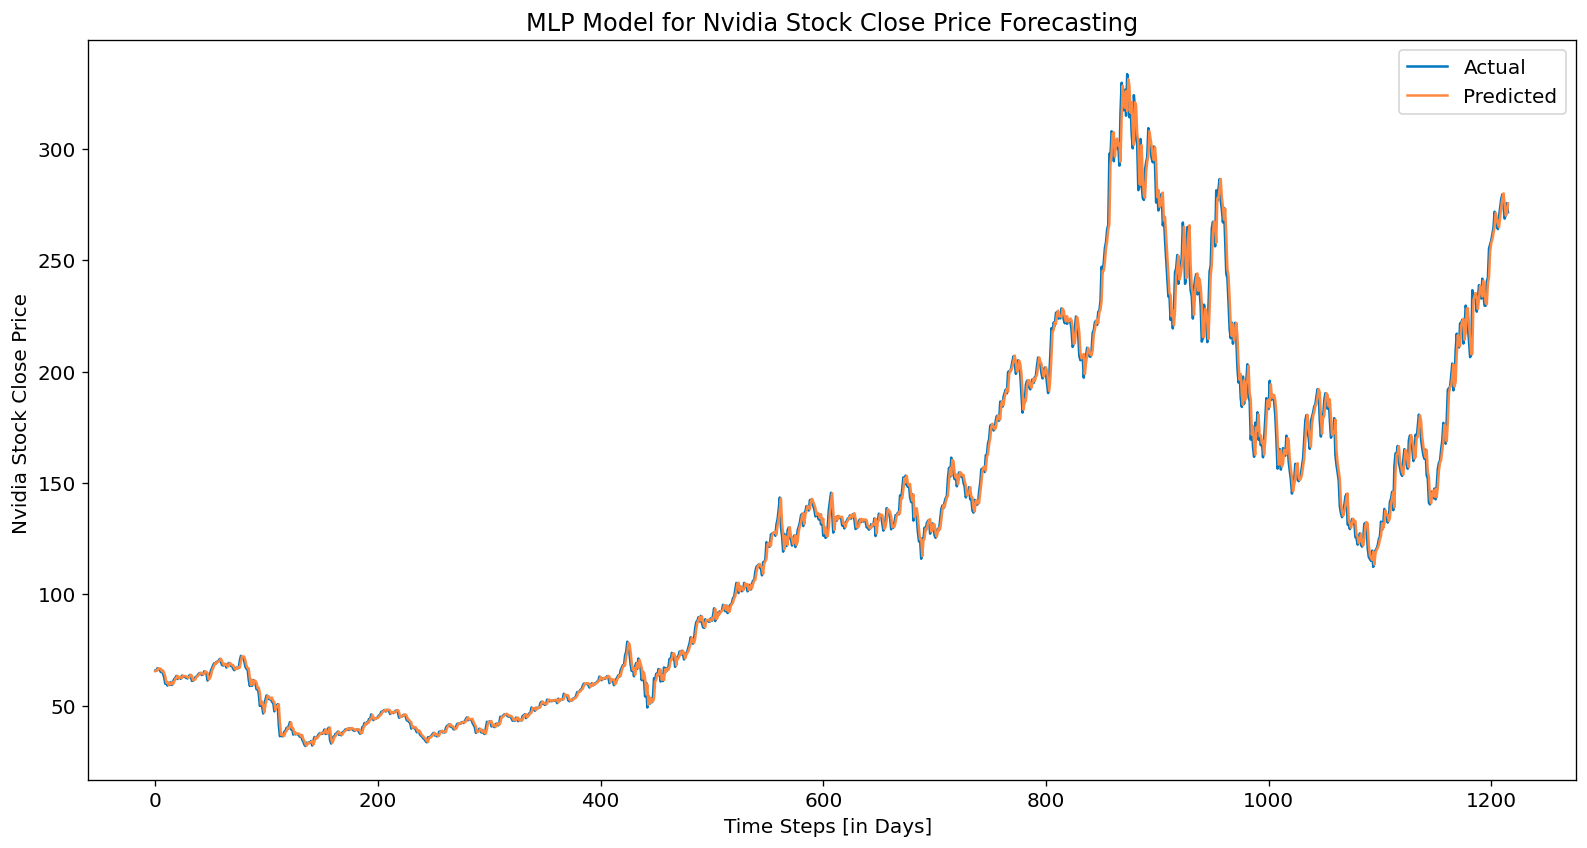

In [39]:
plt.figure(figsize = (16, 8))
plt.rcParams.update({'font.size': 12})
plt.plot(test_y[:], '#0077be', label = 'Actual')
plt.plot(predicted_value, '#ff8841', label = 'Predicted')
plt.title('MLP Model for Nvidia Stock Close Price Forecasting')
plt.ylabel('Nvidia Stock Close Price ')
plt.xlabel('Time Steps [in Days] ')
plt.legend()
plt.show()

## RNN - Univariate Time Series Forecasting


In [40]:
data = dataset2['Close'].values
print('Shape of data: ', data.shape)

Shape of data:  (6094,)


In [41]:
# Separate train and test data
train_length = int(len(data) * 0.8)
print('Train length: ', train_length)

train_data, test_data = data[:train_length], data[train_length:]
print('Shape of Train and Test data: ', len(train_data), len(test_data))

Train length:  4875
Shape of Train and Test data:  4875 1219


In [42]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

### Lag Value already to be chosen from PACF Plot

In [43]:
pacf_value = pacf(data, nlags=20)
lag = 0
# collect lag values greater than 10% correlation 
for x in pacf_value:
    if x > 0.1:
        lag += 1
    else:
        break
print('Selected look_back (or lag = ): ', lag)

Selected look_back (or lag = ):  2


In [44]:
n_features = 1

In [45]:
train_X, train_y = split_sequence(train_data, lag)
test_X, test_y = split_sequence(test_data, lag)

In [46]:
print('Shape of train_X and train_y: ', train_X.shape, train_y.shape)
print('Shape of test_X and test_y: ', test_X.shape, test_y.shape)

Shape of train_X and train_y:  (4873, 2) (4873,)
Shape of test_X and test_y:  (1217, 2) (1217,)


### Reshaping train_X and test_X to 3-D

In [47]:
train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], n_features))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], n_features))

In [48]:
# New shape of train_X and test_X are :-
print('Shape of train_X and train_y: ', train_X.shape, train_y.shape)
print('Shape of test_X and test_y: ', test_X.shape, test_y.shape)

Shape of train_X and train_y:  (4873, 2, 1) (4873,)
Shape of test_X and test_y:  (1217, 2, 1) (1217,)


### Building the model

In [49]:
# define model
model = Sequential()
model.add(SimpleRNN(64, activation='relu', return_sequences = False, input_shape = (lag, n_features)))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 64)                4224      
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 4,289
Trainable params: 4,289
Non-trainable params: 0
_________________________________________________________________


### Fit the model - with training data

In [50]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)

In [51]:
# fit model
cb = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 15, restore_best_weights = True)
history = model.fit(train_X, train_y, epochs = 150, batch_size = 64, verbose = 1, validation_split = 0.1, 
                   callbacks = [cb])

Epoch 1/150
69/69 [==============================] - 2s 32ms/step - loss: 3.5388 - val_loss: 3.8695
Epoch 2/150
69/69 [==============================] - 2s 32ms/step - loss: 0.0304 - val_loss: 2.6950
Epoch 3/150
69/69 [==============================] - 2s 34ms/step - loss: 0.0240 - val_loss: 2.0934
Epoch 4/150
69/69 [==============================] - 2s 35ms/step - loss: 0.0223 - val_loss: 1.6809
Epoch 5/150
69/69 [==============================] - 2s 34ms/step - loss: 0.0217 - val_loss: 1.5039
Epoch 6/150
69/69 [==============================] - 2s 32ms/step - loss: 0.0212 - val_loss: 1.5553
Epoch 7/150
69/69 [==============================] - 2s 36ms/step - loss: 0.0210 - val_loss: 1.3820
Epoch 8/150
69/69 [==============================] - 2s 34ms/step - loss: 0.0207 - val_loss: 1.3351
Epoch 9/150
69/69 [==============================] - 2s 35ms/step - loss: 0.0209 - val_loss: 1.2419
Epoch 10/150
69/69 [==============================] - 2s 33ms/step - loss: 0.0204 - val_loss: 1.2008

### Summarizing model accuracy and Loss

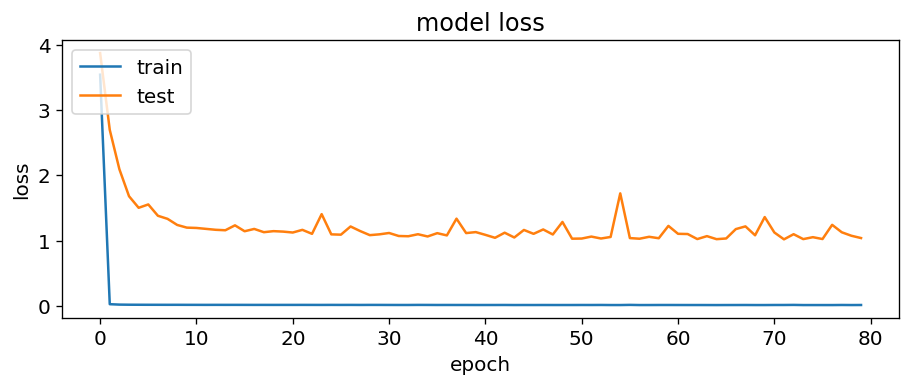

In [52]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

### Making prediction with Test data

In [53]:
train_predict = model.predict(train_X)
test_predict = model.predict(test_X)

print('Shape of train and test predict: ', train_predict.shape, test_predict.shape)

39/39 [==============================] - 0s 10ms/step
Shape of train and test predict:  (4873, 1) (1217, 1)


### Model evaluation

In [54]:
actual_ = test_y
predicted_ = test_predict[:, 0]
len(actual_), len(predicted_)

(1217, 1217)

In [55]:
evaluate_forecast_results(actual_, predicted_)

R2 Score:  1.0
MAE :  3.25
MSE:  26.0
RMSE:  5.1
NRMSE:  0.04
WMAPE:  -0.0006


### Plotting test and predicted data


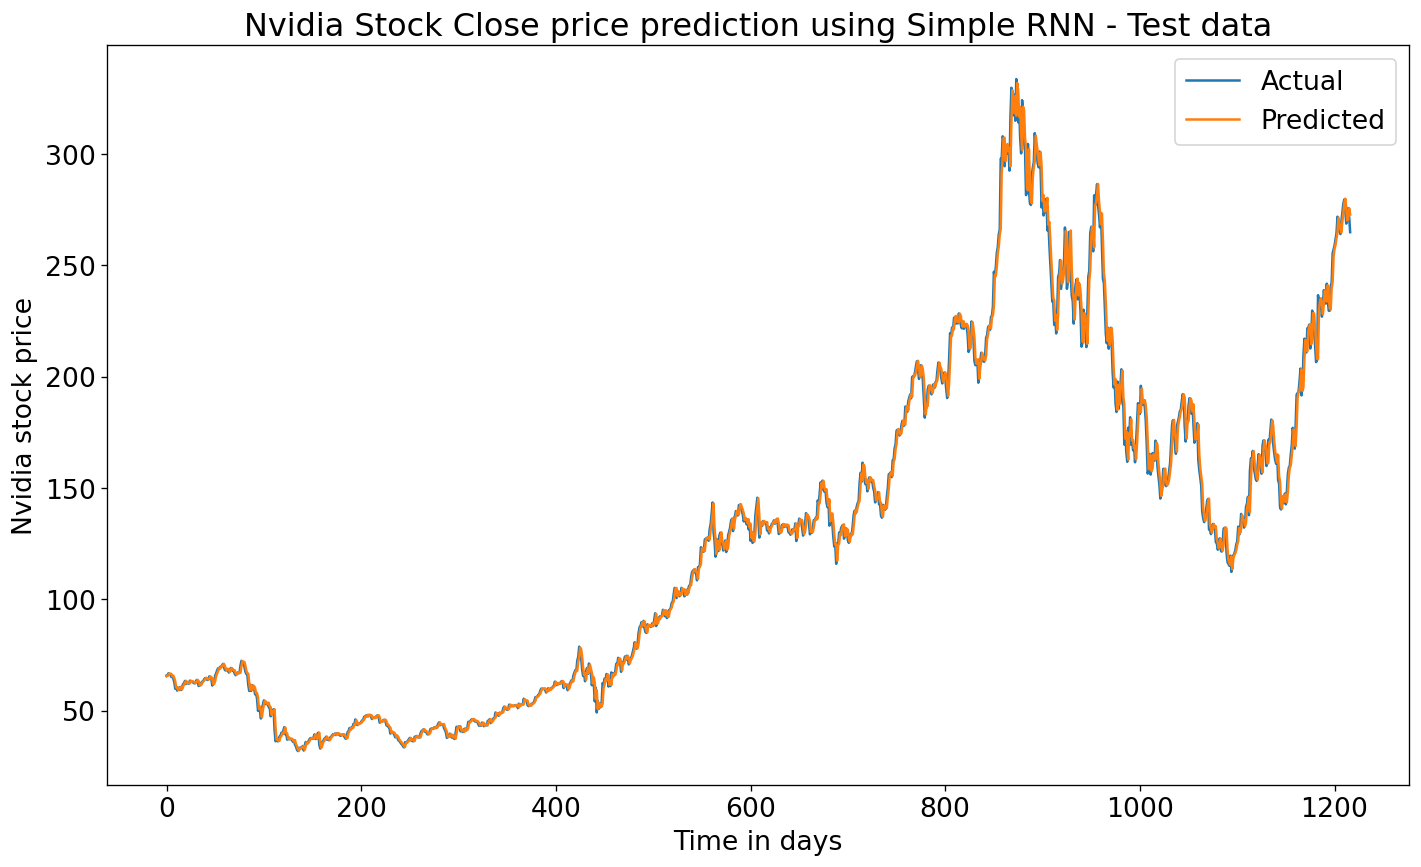

In [56]:
plt.rc("figure", figsize = (14,8))
plt.rcParams.update({'font.size': 16})
plt.plot(actual_, label = 'Actual')
plt.plot(predicted_, label = 'Predicted')
plt.xlabel('Time in days')
plt.ylabel('Nvidia stock price')
plt.title('Nvidia Stock Close price prediction using Simple RNN - Test data')
plt.legend()
plt.show()

In [57]:
df_train = pd.DataFrame(columns = ['Train data'])
df_train['Train data'] = train_data

df = pd.DataFrame(columns = ['Test data', 'Predicted data'])
df['Test data'] = actual_
df['Predicted data'] = predicted_

total_len = len(df_train['Train data']) + len(df['Test data'])
range(len(df_train['Train data']), total_len)
x_list = [x for x in range(len(df_train['Train data']), total_len)]
df.index = x_list

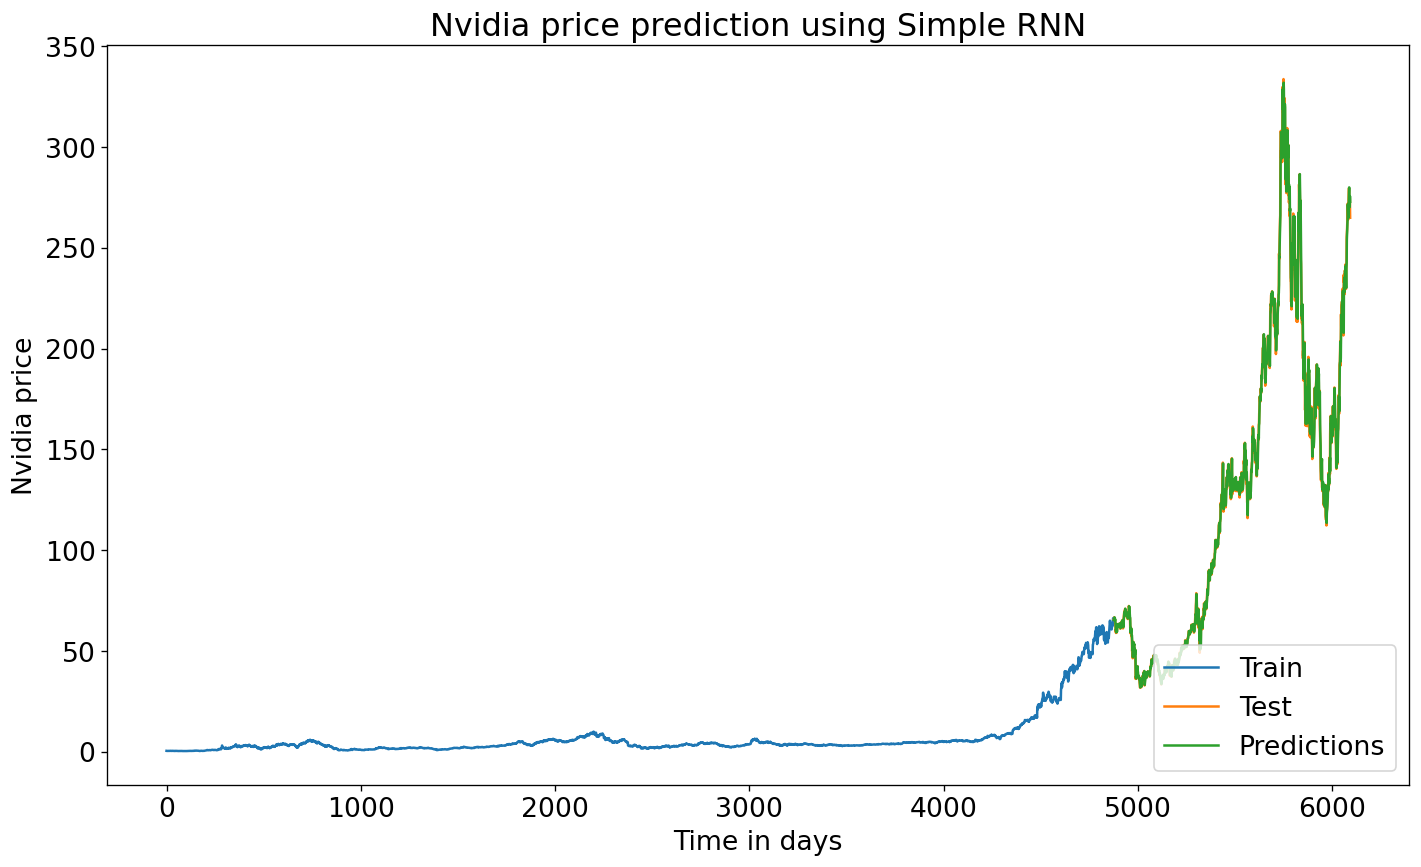

In [58]:
plt.rc("figure", figsize=(14,8))
plt.rcParams.update({'font.size': 16})
plt.xlabel('Time in days')
plt.ylabel('Nvidia price')
plt.title('Nvidia price prediction using Simple RNN')
plt.plot(df_train['Train data'])
plt.plot(df[['Test data', 'Predicted data']])
plt.legend(['Train', 'Test', 'Predictions'], loc='lower right')
plt.show()

##LSTM

In [59]:
data = dataset2['Close'].values
print('Shape of data: ', data.shape)

Shape of data:  (6094,)


In [60]:
# Separate train and test data
train_length = int(len(data) * 0.8)
print('Train length: ', train_length)
train_data, test_data = data[:train_length], data[train_length:]
print('Shape of Train and Test data: ', len(train_data), len(test_data))

Train length:  4875
Shape of Train and Test data:  4875 1219


In [61]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

### Choosing the appropriate lag value

In [62]:
lag = 2  
n_features = 1

In [63]:
train_X, train_y = split_sequence(train_data, lag)
test_X, test_y = split_sequence(test_data, lag)

print('Shape of train_X and train_y: ', train_X.shape, train_y.shape)
print('Shape of test_X and test_y: ', test_X.shape, test_y.shape)

Shape of train_X and train_y:  (4873, 2) (4873,)
Shape of test_X and test_y:  (1217, 2) (1217,)


### Reshaping train_X and test_X to 3D

In [64]:
train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], n_features))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], n_features))

print('Shape of train_X and train_y: ', train_X.shape, train_y.shape)
print('Shape of test_X and test_y: ', test_X.shape, test_y.shape)

Shape of train_X and train_y:  (4873, 2, 1) (4873,)
Shape of test_X and test_y:  (1217, 2, 1) (1217,)


### Building LSTM Model

In [65]:
model = Sequential()
model.add(LSTM(64, activation = 'relu', return_sequences = True, input_shape = (lag, n_features)))
model.add(LSTM(64, activation = 'relu'))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 2, 64)             16896     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________


### Fitting model with data

In [66]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)

In [67]:
cb = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 15, restore_best_weights = True)
history = model.fit(train_X, train_y, epochs = 150, batch_size = 64, verbose = 1, validation_split =  0.1, 
                   callbacks = [cb])

Epoch 1/150
69/69 [==============================] - 5s 66ms/step - loss: 8.2824 - val_loss: 1908.7234
Epoch 2/150
69/69 [==============================] - 5s 66ms/step - loss: 0.4277 - val_loss: 60.7218
Epoch 3/150
69/69 [==============================] - 4s 62ms/step - loss: 0.0411 - val_loss: 229.2045
Epoch 4/150
69/69 [==============================] - 4s 64ms/step - loss: 0.0292 - val_loss: 201.1389
Epoch 5/150
69/69 [==============================] - 4s 62ms/step - loss: 0.0275 - val_loss: 188.4526
Epoch 6/150
69/69 [==============================] - 4s 64ms/step - loss: 0.0268 - val_loss: 173.8143
Epoch 7/150
69/69 [==============================] - 4s 64ms/step - loss: 0.0265 - val_loss: 140.5205
Epoch 8/150
69/69 [==============================] - 4s 61ms/step - loss: 0.0263 - val_loss: 118.8386
Epoch 9/150
69/69 [==============================] - 4s 63ms/step - loss: 0.0259 - val_loss: 107.5581
Epoch 10/150
69/69 [==============================] - 5s 67ms/step - loss: 0.0252 

### Summarizing model accuracy and Loss

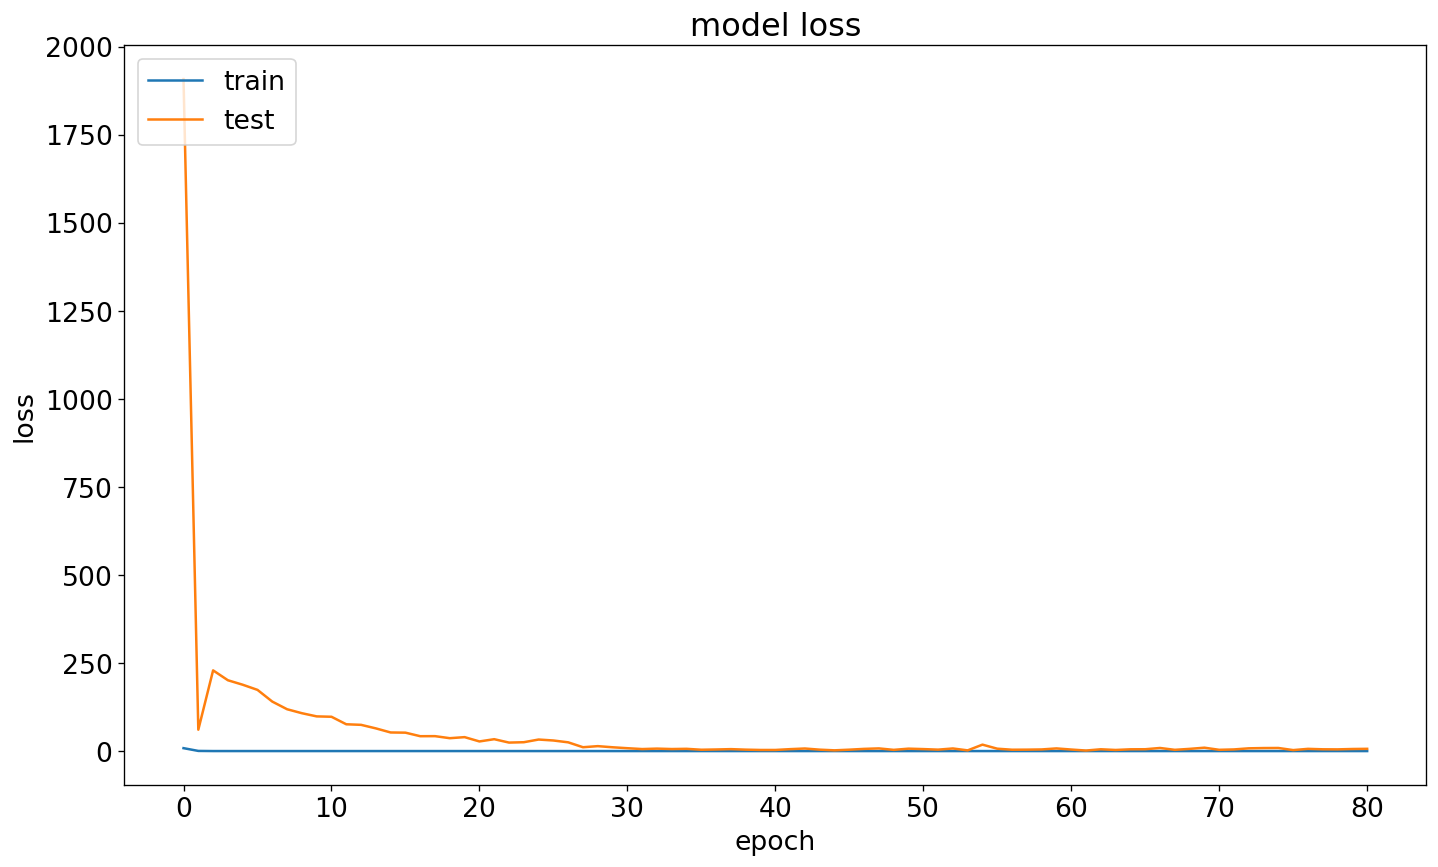

In [68]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

### Making the prediction

In [69]:
train_predict = model.predict(train_X)
test_predict = model.predict(test_X)

print('Shape of train and test predict: ', train_predict.shape, test_predict.shape)

39/39 [==============================] - 1s 21ms/step
Shape of train and test predict:  (4873, 1) (1217, 1)


### Model Evaluation

In [70]:
actual_lstm = test_y
predicted_lstm = test_predict[:, 0]
evaluate_forecast_results(actual_lstm, predicted_lstm)

R2 Score:  0.83
MAE :  22.44
MSE:  956.39
RMSE:  30.93
NRMSE:  0.2426
WMAPE:  0.1754


In [71]:
df_train = pd.DataFrame(columns = ['Train data'])
df_train['Train data'] = train_data

df = pd.DataFrame(columns = ['Test data', 'Predicted data'])
df['Test data'] = actual_lstm
df['Predicted data'] = predicted_lstm

total_len = len(df_train['Train data']) + len(df['Test data'])
range(len(df_train['Train data']), total_len)
x_list = [x for x in range(len(df_train['Train data']), total_len)]
df.index = x_list

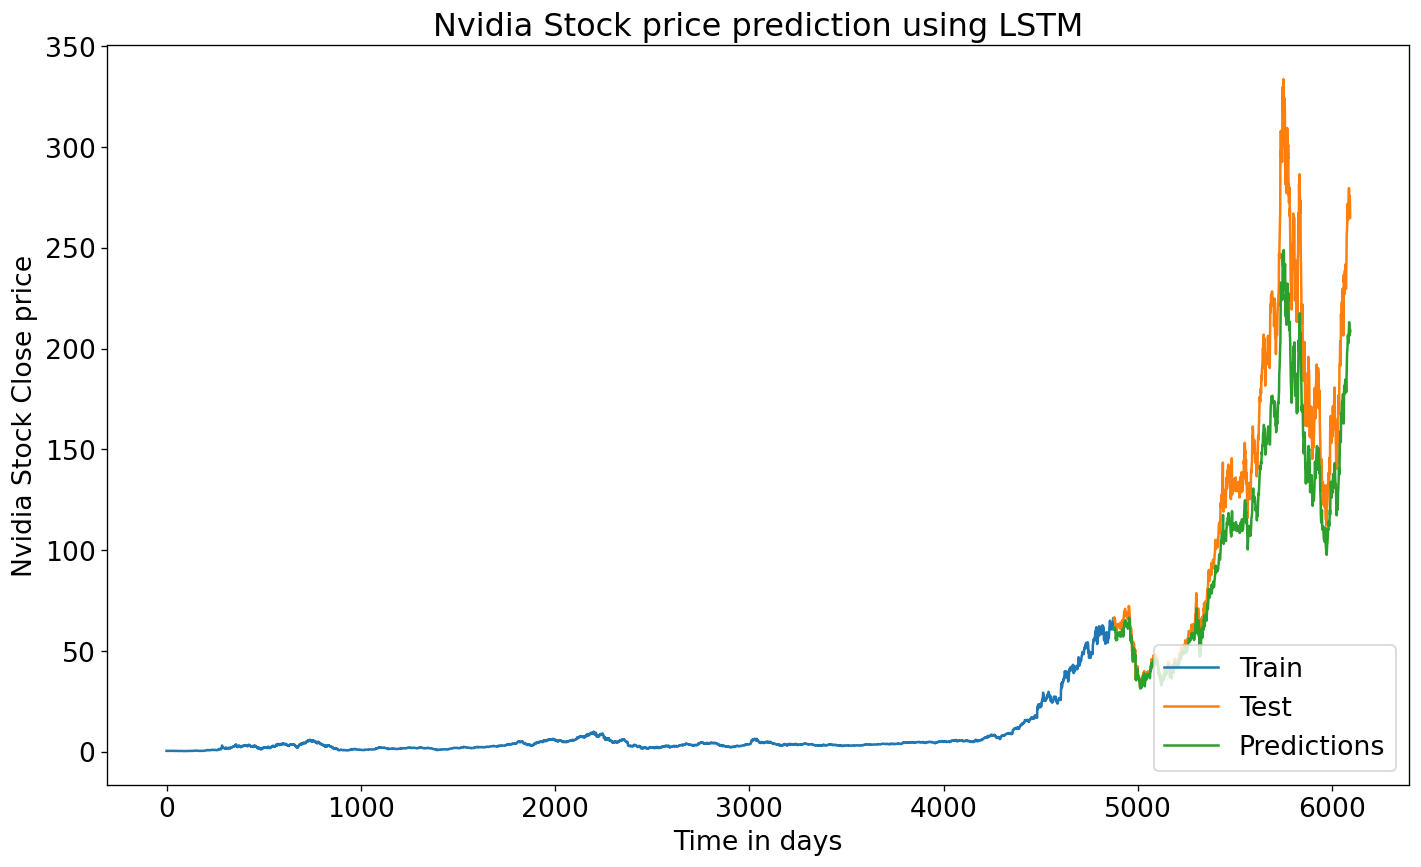

In [72]:
plt.rc("figure", figsize = (14,8))
plt.rcParams.update({'font.size': 16})
plt.xlabel('Time in days')
plt.ylabel('Nvidia Stock Close price')
plt.title('Nvidia Stock price prediction using LSTM')
plt.plot(df_train['Train data'])
plt.plot(df[['Test data', 'Predicted data']])
plt.legend(['Train', 'Test', 'Predictions'], loc = 'lower right')
plt.show()

Thanks for sparing your time! Do upvote if you liked it, This motivates hugely to come up with new explorations and keep exploring new domains.

It would be really nice if you check my other works and if you like my work then don't forget to follow for more interesting notebooks 🤗